In [1]:
import os
import sys
import json
import numpy as np
sys.path.insert(0, '../pybswarm')

import numpy as np
import bswarm.trajectory_generation as tgen
import bswarm.formation as form
import bswarm

import plotly
import plotly.graph_objs as go

# Configure Plotly to be rendered inline in the notebook.
plotly.offline.init_notebook_mode()

# A flat P formation

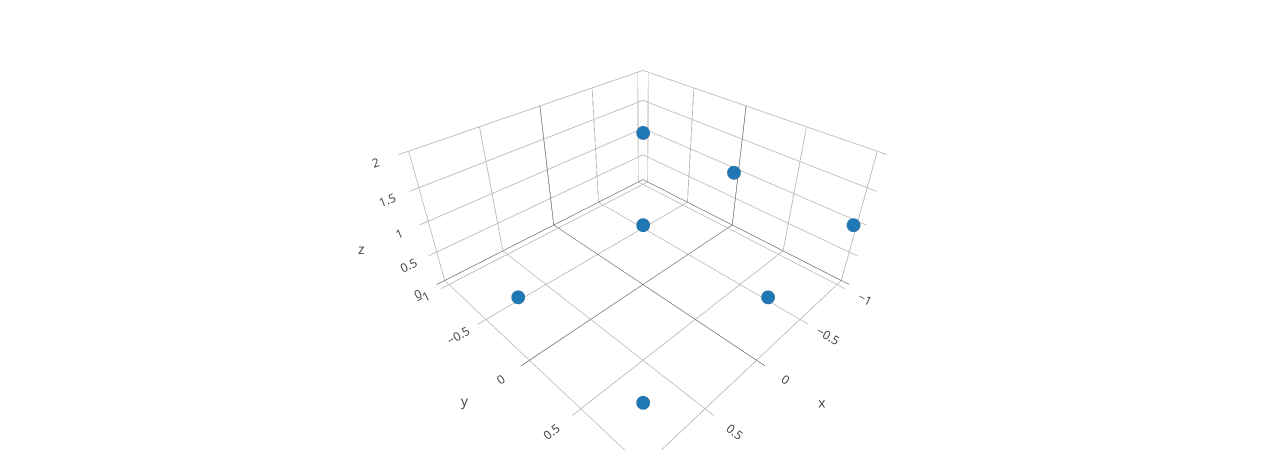

In [2]:
P = np.array([
    [-1, 1, 1],
    [0, 1, 1],
    [1, 1, 1],
    [-1, 0, 1],
    [0, 0, 1],
    [1, 0, 1],
    [-1, -1, 1]
]).T

t = np.linspace(0, 4*np.pi, 100)

plot_figure = go.Figure(
    data=[
        go.Scatter3d(
        x=P[0, :], y=P[1, :], z=P[2, :],
        mode='markers'
        )
    ],
    layout=go.Layout(
        margin={'l': 0, 'r': 0, 'b': 0, 't': 0},
        scene={'xaxis': {'title': 'x'}}
    )
)
plotly.offline.iplot(plot_figure)

# A slanted P formation

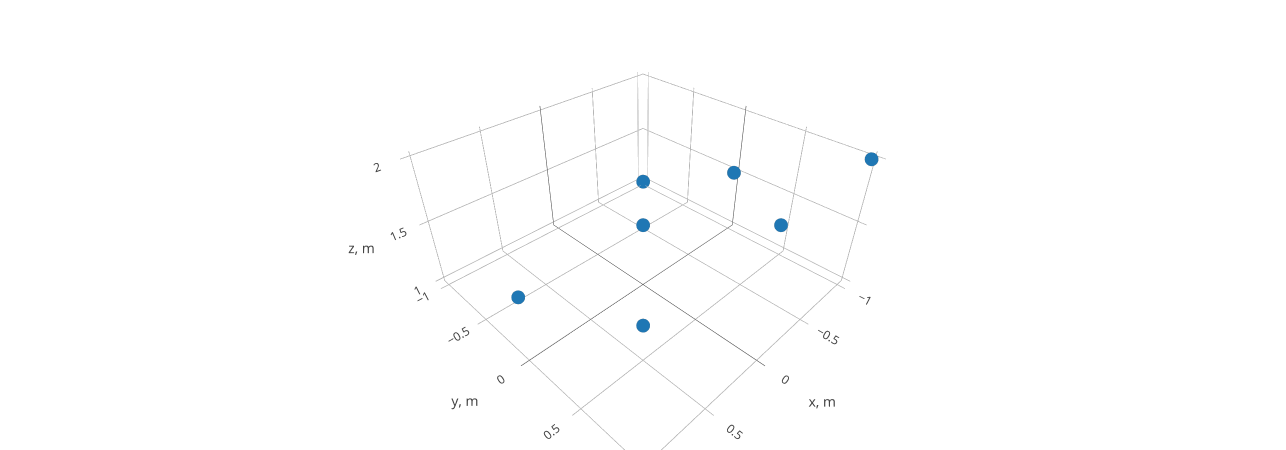

In [3]:
P2 = np.array([
    [-1, 1, 2],
    [0, 1, 2],
    [1, 1, 2],
    [-1, 0, 1.5],
    [0, 0, 1.5],
    [1, 0, 1.5],
    [-1, -1, 1]
]).T

layout=go.Layout(
    margin={'l': 0, 'r': 0, 'b': 0, 't': 0},
    scene={
        'xaxis': {'title': 'x, m'},
        'yaxis': {'title': 'y, m'},
        'zaxis': {'title': 'z, m'}
    }
)

plot_figure = go.Figure(
    data=[
        go.Scatter3d(
        x=P2[0, :], y=P2[1, :], z=P2[2, :],
        mode='markers'
        )
    ],
    layout=layout
)
plotly.offline.iplot(plot_figure)

# Rotated Slanted P Waypoints

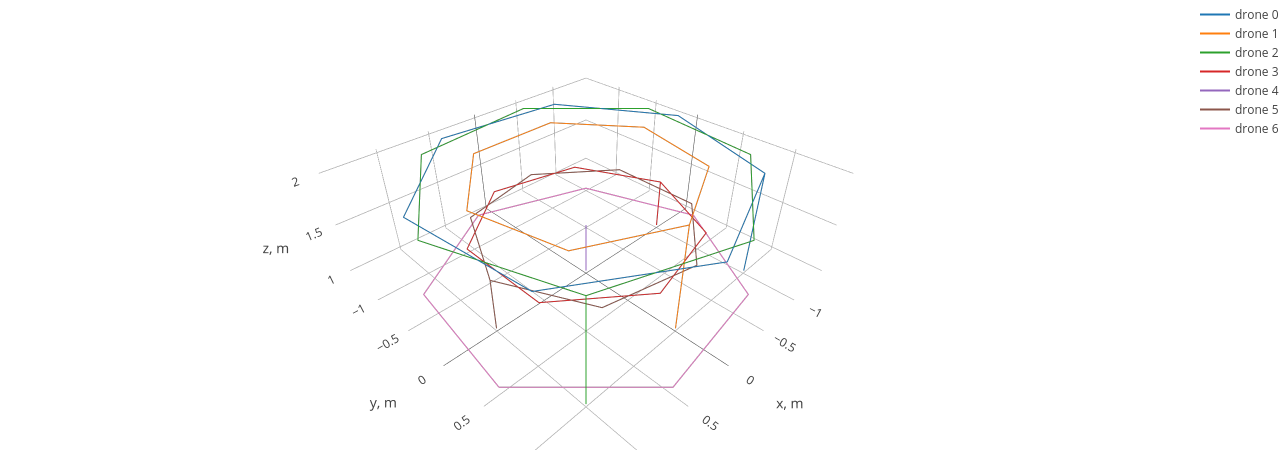

In [4]:
# %% Create waypoints for flat P -> slanted P -> rotating slanted P -> flat P
waypoints = [P]
for theta in np.linspace(0, 2 * np.pi, 8):
    waypoints.append(form.rotate_points_z(P2, theta))
waypoints.append(P)
waypoints = np.array(waypoints)

data = []
for point in range(waypoints.shape[2]):
    data.append(go.Scatter3d(
        x=waypoints[:, 0, point], y=waypoints[:, 1, point], z=waypoints[:, 2, point],
        mode='lines',
        name='drone {:d}'.format(point)
        ))

plot_figure = go.Figure(data=data, layout=layout)
plotly.offline.iplot(plot_figure)

# Trajectory Planning

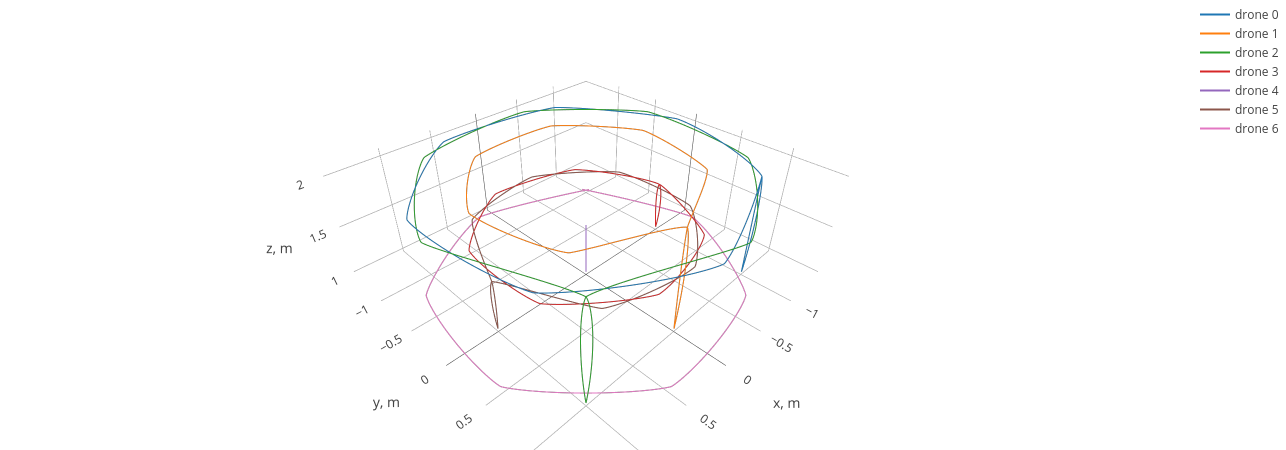

In [5]:
def create_trajectory(waypoints):
    dist = np.linalg.norm(waypoints[1:, :, :] - waypoints[:-1, :, :], axis=1)
    dist_max = np.max(dist, axis=1)
    planner = tgen.plan_min_snap
    drone_list = []
    T = 1 * np.ones(dist.shape[0])
    for drone in range(waypoints.shape[2]):
        trajx = planner(waypoints[:, 0, drone], T)
        trajy = planner(waypoints[:, 1, drone], T)
        trajz = planner(waypoints[:, 2, drone], T)
        drone_list.append([trajx, trajy, trajz])
    return drone_list

def drone_list_to_json(drone_list):
    formation = {}
    n = 8
    cyaw = np.zeros(n)
    for drone, traj in enumerate(drone_list):
        data=[]
        cx = traj[0].c
        cy = traj[1].c
        cz = traj[2].c
        T = traj[0].T
        for leg in range(len(T)):
            cxi = np.flip(cx[n*leg:n*(leg+1)],0)
            cyi = np.flip(cy[n*leg:n*(leg+1)],0)
            czi = np.flip(cz[n*leg:n*(leg+1)],0)
            data.append(np.hstack([T[leg],cxi,cyi,czi,cyaw]))
        formation[drone] = np.array(data).tolist()
    return formation

def plot_trajectory(drone_list):
    data = []
    for drone, traj in enumerate(drone_list):
        data.append(go.Scatter3d(
            x=traj[0].compute_trajectory()['x'], y=traj[1].compute_trajectory()['x'], z=traj[2].compute_trajectory()['x'],
            mode='lines',
            name='drone {:d}'.format(drone)
            ))
    plot_figure = go.Figure(data=data, layout=layout)
    plotly.offline.iplot(plot_figure)

drone_list = create_trajectory(waypoints)
plot_trajectory(drone_list)

with open('data/new_formation.json', 'w') as f:
    drone_json = drone_list_to_json(drone_list)
    f.write(json.dumps(drone_json))

# Time History of Trajectories

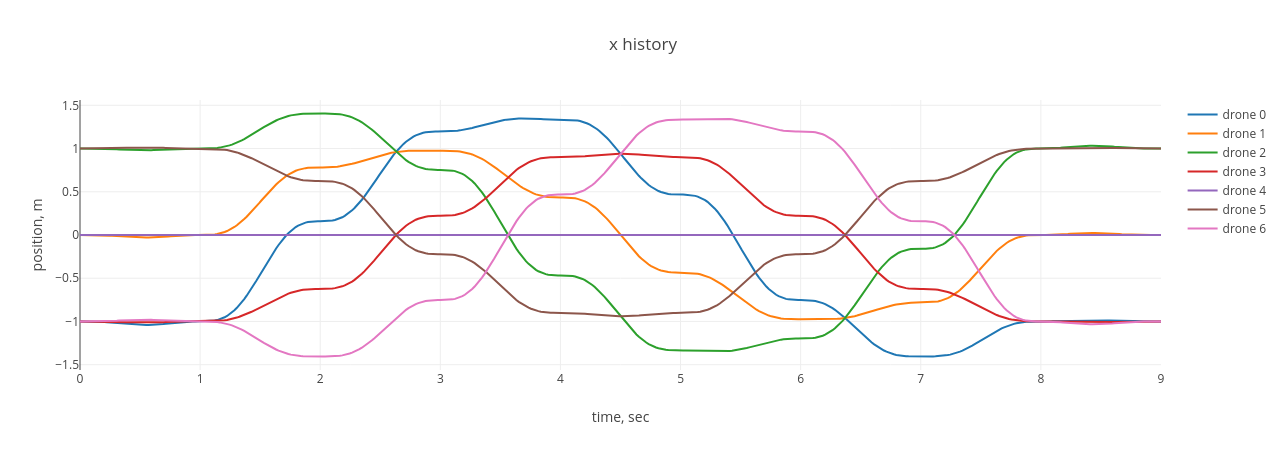

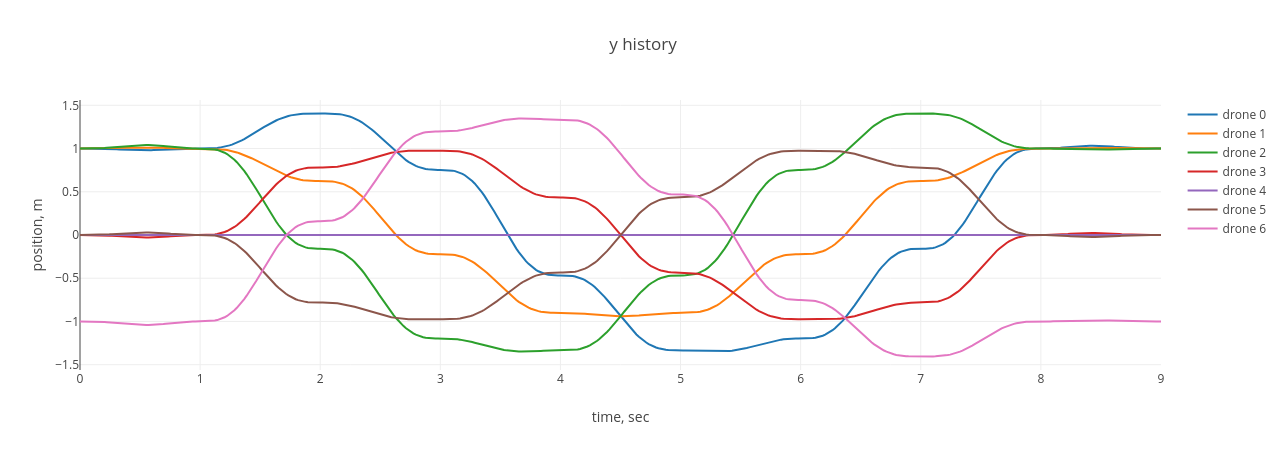

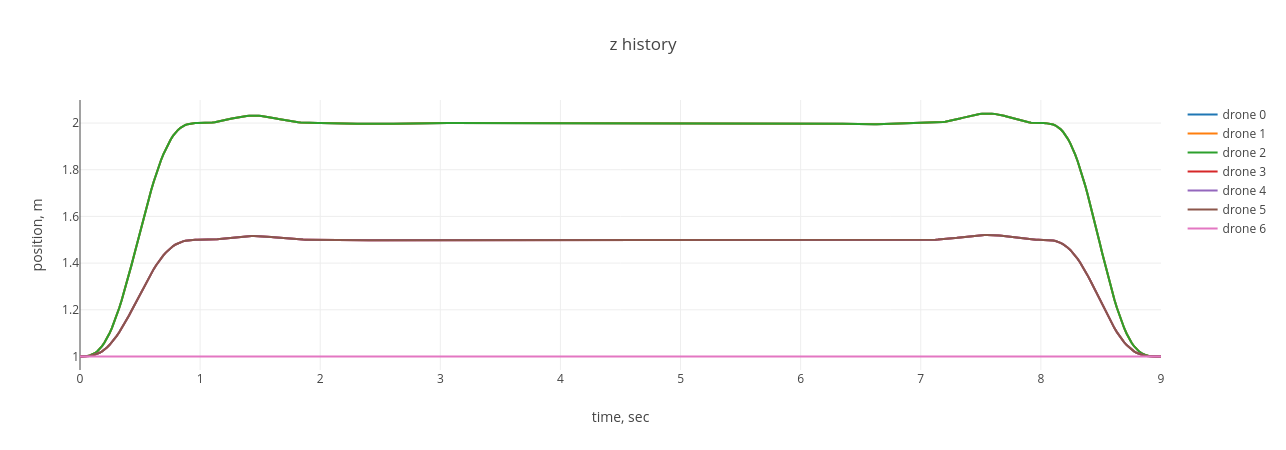

In [6]:
def do_time_plots():
    for index, name in zip((0, 1, 2), ('x', 'y', 'z')):
        data = []
        layout2={
            'margin': {'l': 0, 'r': 0, 'b': 0, 't': 0},
            'scene': {
                'xaxis': {'title': 't, s'},
                'yaxis': {'title': name + ', m'}
            }
        }
        layout = go.Layout(title=name + ' history', xaxis=go.layout.XAxis(title='time, sec'), yaxis=go.layout.YAxis(title='position, m'))

        for drone, traj in enumerate(drone_list):
            data.append(go.Scatter(
                x=traj[index].compute_trajectory()['t'], y=traj[index].compute_trajectory()['x'],
                mode='lines',
                name='drone {:d}'.format(drone)
                ))
        plot_figure = go.Figure(data=data, layout=layout)
        plotly.offline.iplot(plot_figure)

do_time_plots()